In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from random import random
from glob import glob
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data exploration

In [4]:
df = pd.read_csv("./datasets/chinesemnist/chinese_mnist.csv")
df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [5]:
paths = glob("./datasets/chinesemnist/data/data/*.jpg")
# Shuffle paths
paths = np.random.permutation(paths)
# Split into train, validation, and test with 70%, 15%, 15% split
train_paths = paths[:int(len(paths)*0.7)]
val_paths = paths[int(len(paths)*0.7):int(len(paths)*0.85)]
test_paths = paths[int(len(paths)*0.85):]
print(len(train_paths), len(val_paths), len(test_paths))

10500 2250 2250


In [6]:
def load_images(paths):
    images = []
    ids = []
    for path in paths:
        char_idx = int(path.split("_")[-1][:-4])
        images.append(plt.imread(path))
        ids.append(char_idx)
    return np.array(images), ids

train_images, train_ids = load_images(train_paths)
val_images, val_ids = load_images(val_paths)
test_images, test_ids = load_images(test_paths)
print(train_images.shape, val_images.shape, test_images.shape)

(10500, 64, 64) (2250, 64, 64) (2250, 64, 64)


Now we have a dataset 
$$
(X_{i...N_{train/test/val}}, Y_{i...N_{train/test/val}})
$$ 
Where $X_{train_i} \in \mathbb{R^{64 \times 64}}$ is a train image example of dimensions 64 by 64 pixels. and $Y_i \in \mathbb{Z}$ represents the character index 

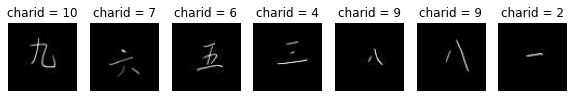

In [7]:
nsamples = 7
for i in range(nsamples):
    plt.subplot(1, nsamples, i+1).imshow(train_images[i], cmap="gray")
    plt.subplot(1, nsamples, i+1).set_title(f"charid = {train_ids[i]}")
    plt.axis("off")
plt.gcf().set_size_inches(10, 10)
plt.show()

We want to match the images head to head in a fully connected manner such that the new dataset will be pairs of images and a similarity score.
$$
(X^l_{i...N_{train/test/val} \times N_{train/test/val}}, X^r_{i...N_{train/test/val} \times N_{train/test/val}}, Y_{i...N_{train/test/val} \times N_{train/test/val}})
$$
Where $X^l_{train_i} \in \mathbb{R^{64 \times 64}}$ is a the left image example of dimensions 64 by 64 pixels. and $Y_i \in [0..1] \subset \mathbb{R}$ represents the similarity score

In [8]:
def indices2similarities(X, Y):
    N = len(X)
    D = []
    for i in range(N):
        for j in range(N):
            left = X[i]
            right = X[j]
            score = 1.0 if Y[i] == Y[j] else 0.0
            D.append((left, right, score))
    return D

def get_sim_example(X, Y, i):
    N = len(X)**2
    if i >= N:
        raise ValueError("i must be less than len(X)**2")
    row = i // N
    col = i % len(X)
    left = X[row]
    right = X[col]
    score = 1.0 if Y[row] == Y[col] else 0.0
    return left, right, score
    
def plot_sample(left, right, score):
    plt.subplot(1, 2, 1).imshow(left, cmap="gray")
    plt.subplot(1, 2, 2).imshow(right, cmap="gray")
    plt.title(f"match={score==1}, sample={i}")
    plt.axis("off")

def plot_example_i(X, Y, i):
    left, right, score = get_sim_example(X, Y, i)
    plot_sample(left, right, score)

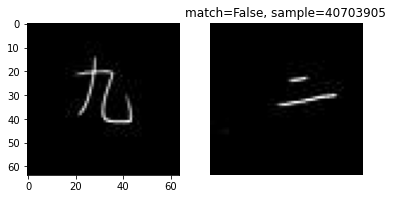

In [9]:
# Get random sample
i = np.random.randint(0, len(train_images)**2)
plot_example_i(train_images, train_ids, i)

**Potential problem**: Since there are $N \times N$ examples, assuming that image $X_i$ matches with $m$ other samples, then there are $N*m$ matching examples, therefore, the portion of matching examples in the dataset is 
$$
portion = \frac{N\cdot m}{N \times N} = \frac{m}{N}
$$
Therefore, you can already see that the portion becomes smaller in an exponential decay maner as $N$ grows, which can create a considerable data imbalance.

### Creating the datasets
Now that we have defined our dataset, we can create a PyTorch dataset that will be used for the later stages of training.

In [10]:

class ToTensor:

    def __call__(self, image):
       return torch.from_numpy(image)

transform = transforms.Compose([
    transforms.RandomInvert(),
    transforms.RandomChoice([
        transforms.RandomRotation(40),
        transforms.GaussianBlur(5),
        transforms.RandomPerspective()
    ])
])

In [11]:
class ChineseMNISTDataset(Dataset):

    def __init__(self, X, Y, transform=None, m=8):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.m = m
    
    def __len__(self):
        return self.X.shape[0] * self.m
    
    def __getitem__(self, index):
        N = self.X.shape[0]
        choice = np.random.choice([0, 1])
        row = i // N
        col = np.random.randint(0, N)
        score = 1.0 if self.Y[row] == self.Y[col] else 0.0
        while not score == choice:
            col = np.random.randint(0, N)
            score = 1.0 if self.Y[row] == self.Y[col] else 0.0
        left = self.X[row]
        right = self.X[col]
        left = self.__process_raw_image(left)
        right = self.__process_raw_image(right)

        if self.transform:
            left = self.transform(left)
            right = self.transform(right)
        return left, right, score

    def __process_raw_image(self, x):
        # Add a channel
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)
        x /= 255.0
        return x

In [12]:
train_ds = ChineseMNISTDataset(train_images, train_ids)
val_ds = ChineseMNISTDataset(val_images, val_ids)
test_ds = ChineseMNISTDataset(test_images, test_ids)

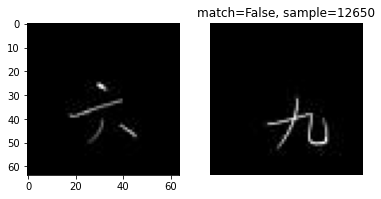

In [13]:
# Get random sample
i = np.random.randint(0, len(train_ds))
left, right, score = train_ds[i]
plot_sample(left[0], right[0], score)

## Modelling

In [14]:
from model import SiameseNetwork
from torch.nn import CosineEmbeddingLoss, CrossEntropyLoss
from losses import ContrastiveLoss
from torchmetrics.classification import BinaryF1Score
import tqdm

model = SiameseNetwork().to(device)
criterion = ContrastiveLoss().to(device)
metric = BinaryF1Score().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

f"{sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters"

'29137473 trainable parameters'

In [15]:
N = 300
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=True)
print(len(train_loader.dataset), len(val_loader.dataset))

21000 4500


100%|██████████| 18/18 [00:01<00:00, 13.03it/s]


Epoch 1/300, epoch_loss 1.007, epoch_metric=0.000, val_loss 1.955, val_metric 0.669


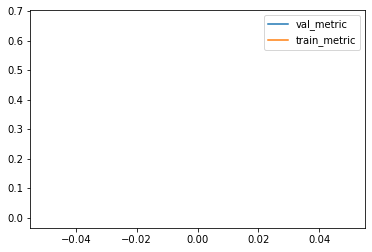

100%|██████████| 18/18 [00:01<00:00, 13.00it/s]


Epoch 2/300, epoch_loss 1.009, epoch_metric=0.000, val_loss 1.919, val_metric 0.672


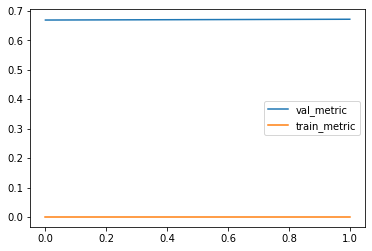

100%|██████████| 18/18 [00:01<00:00, 12.97it/s]

Epoch 3/300, epoch_loss 1.008, epoch_metric=0.000, val_loss 1.932, val_metric 0.668


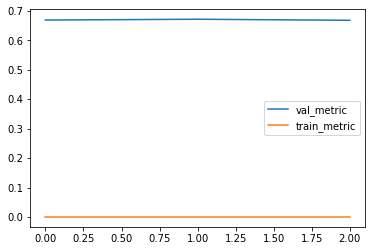

100%|██████████| 18/18 [00:01<00:00, 13.03it/s]

Epoch 4/300, epoch_loss 1.012, epoch_metric=0.000, val_loss 1.904, val_metric 0.663


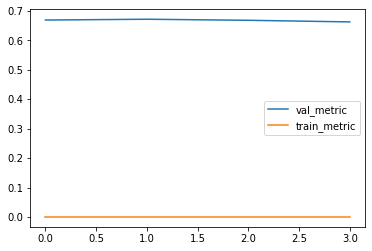

100%|██████████| 18/18 [00:01<00:00, 12.95it/s]

Epoch 5/300, epoch_loss 1.007, epoch_metric=0.000, val_loss 1.592, val_metric 0.671


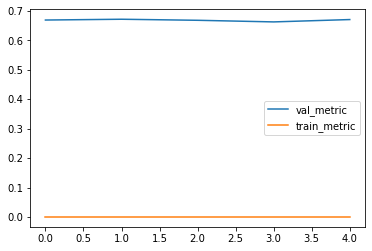

100%|██████████| 18/18 [00:01<00:00, 12.95it/s]

Epoch 6/300, epoch_loss 1.002, epoch_metric=0.000, val_loss 1.603, val_metric 0.668


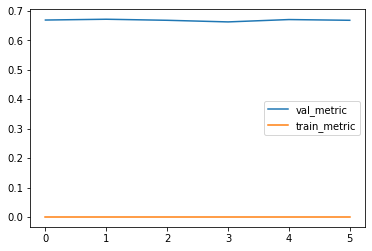

100%|██████████| 18/18 [00:01<00:00, 12.94it/s]


Epoch 7/300, epoch_loss 0.960, epoch_metric=0.000, val_loss 1.550, val_metric 0.696


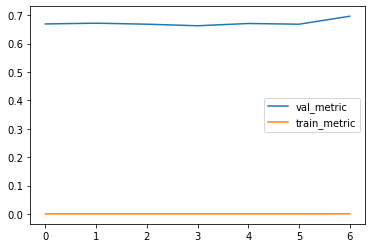

100%|██████████| 18/18 [00:01<00:00, 12.95it/s]


Epoch 8/300, epoch_loss 0.930, epoch_metric=0.004, val_loss 0.763, val_metric 0.838


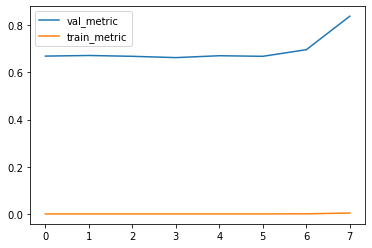

100%|██████████| 18/18 [00:01<00:00, 12.93it/s]


Epoch 9/300, epoch_loss 0.872, epoch_metric=0.007, val_loss 0.709, val_metric 0.841


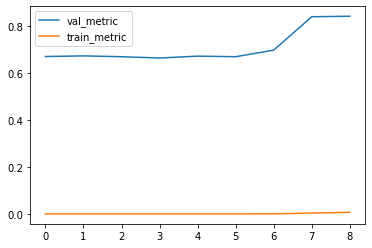

100%|██████████| 18/18 [00:01<00:00, 12.83it/s]

Epoch 10/300, epoch_loss 0.882, epoch_metric=0.030, val_loss 0.405, val_metric 0.704


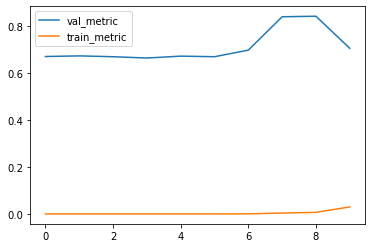

100%|██████████| 18/18 [00:01<00:00, 12.82it/s]


Epoch 11/300, epoch_loss 0.784, epoch_metric=0.154, val_loss 0.398, val_metric 0.775


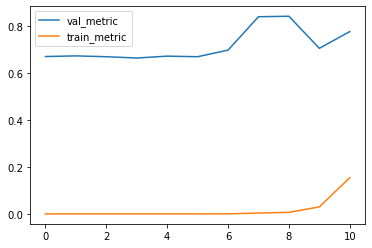

100%|██████████| 18/18 [00:01<00:00, 12.81it/s]

Epoch 12/300, epoch_loss 0.710, epoch_metric=0.285, val_loss 0.375, val_metric 0.825


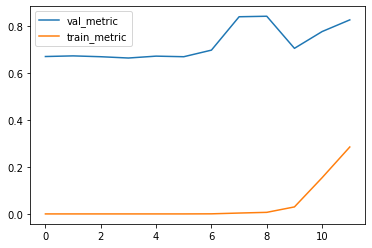

100%|██████████| 18/18 [00:01<00:00, 12.84it/s]

Epoch 13/300, epoch_loss 0.691, epoch_metric=0.433, val_loss 0.331, val_metric 0.824


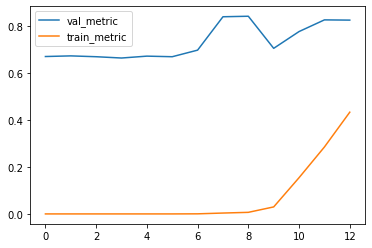

100%|██████████| 18/18 [00:01<00:00, 12.80it/s]


Epoch 14/300, epoch_loss 0.661, epoch_metric=0.469, val_loss 0.331, val_metric 0.876


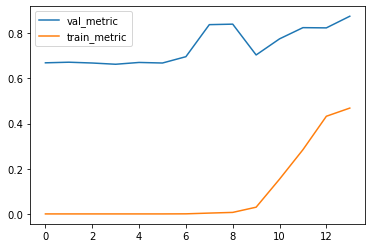

100%|██████████| 18/18 [00:01<00:00, 12.95it/s]

Epoch 15/300, epoch_loss 0.635, epoch_metric=0.519, val_loss 0.401, val_metric 0.752


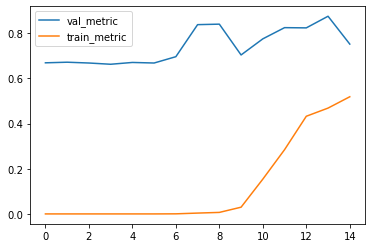

100%|██████████| 18/18 [00:01<00:00, 12.84it/s]


Epoch 16/300, epoch_loss 0.703, epoch_metric=0.484, val_loss 0.383, val_metric 0.906


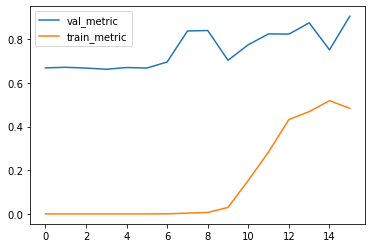

100%|██████████| 18/18 [00:01<00:00, 12.95it/s]

Epoch 17/300, epoch_loss 0.554, epoch_metric=0.599, val_loss 0.278, val_metric 0.806


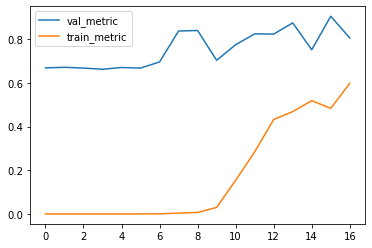

100%|██████████| 18/18 [00:01<00:00, 12.93it/s]

Epoch 18/300, epoch_loss 0.566, epoch_metric=0.574, val_loss 0.277, val_metric 0.812


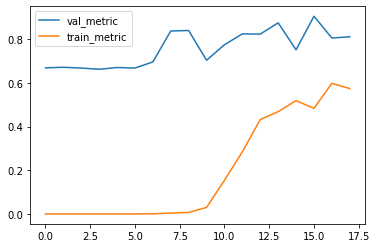

100%|██████████| 18/18 [00:01<00:00, 12.90it/s]

Epoch 19/300, epoch_loss 0.458, epoch_metric=0.701, val_loss 0.220, val_metric 0.872


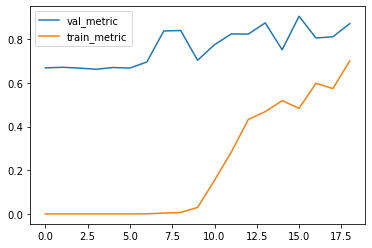

100%|██████████| 18/18 [00:01<00:00, 12.89it/s]


Epoch 20/300, epoch_loss 0.413, epoch_metric=0.729, val_loss 0.164, val_metric 0.928


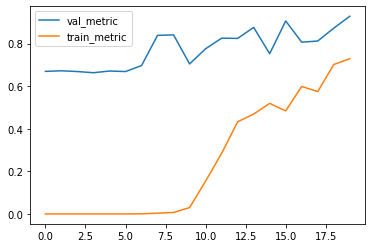

100%|██████████| 18/18 [00:01<00:00, 13.00it/s]

Epoch 21/300, epoch_loss 0.446, epoch_metric=0.731, val_loss 0.157, val_metric 0.914


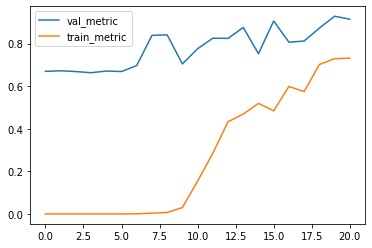

100%|██████████| 18/18 [00:01<00:00, 12.91it/s]

Epoch 22/300, epoch_loss 0.386, epoch_metric=0.764, val_loss 0.499, val_metric 0.912


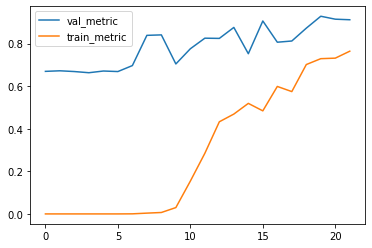

100%|██████████| 18/18 [00:01<00:00, 12.92it/s]

Epoch 23/300, epoch_loss 0.314, epoch_metric=0.813, val_loss 0.167, val_metric 0.889


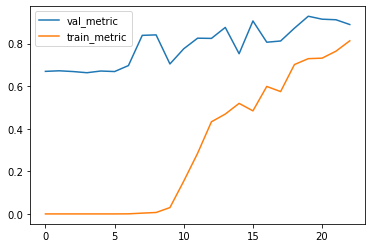

100%|██████████| 18/18 [00:01<00:00, 12.96it/s]


Epoch 24/300, epoch_loss 0.291, epoch_metric=0.832, val_loss 0.094, val_metric 0.934


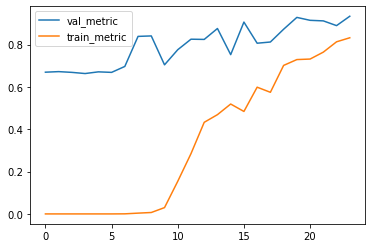

100%|██████████| 18/18 [00:01<00:00, 12.95it/s]


Epoch 25/300, epoch_loss 0.331, epoch_metric=0.802, val_loss 0.087, val_metric 0.966


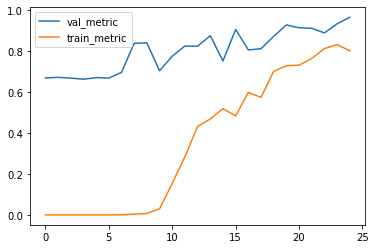

100%|██████████| 18/18 [00:01<00:00, 12.97it/s]

Epoch 26/300, epoch_loss 0.238, epoch_metric=0.869, val_loss 0.084, val_metric 0.931


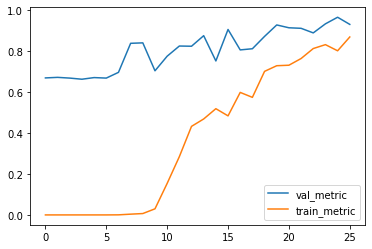

100%|██████████| 18/18 [00:01<00:00, 12.92it/s]


Epoch 27/300, epoch_loss 0.227, epoch_metric=0.869, val_loss 0.058, val_metric 0.981


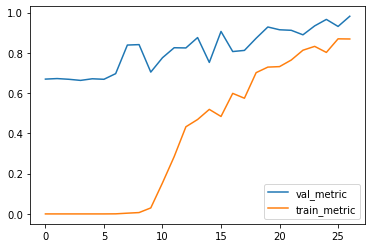

100%|██████████| 18/18 [00:01<00:00, 12.91it/s]

Epoch 28/300, epoch_loss 0.371, epoch_metric=0.811, val_loss 0.081, val_metric 0.976


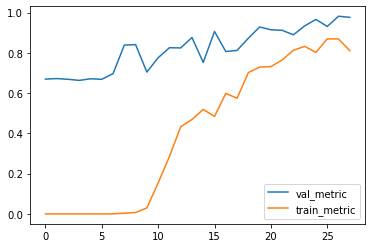

100%|██████████| 18/18 [00:01<00:00, 12.95it/s]


Epoch 29/300, epoch_loss 0.301, epoch_metric=0.825, val_loss 0.086, val_metric 0.991


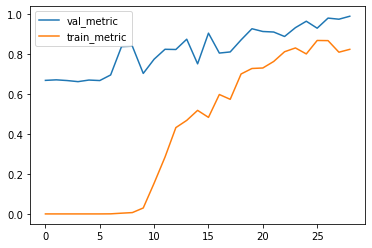

100%|██████████| 18/18 [00:01<00:00, 12.90it/s]

Epoch 30/300, epoch_loss 0.229, epoch_metric=0.877, val_loss 0.047, val_metric 0.979


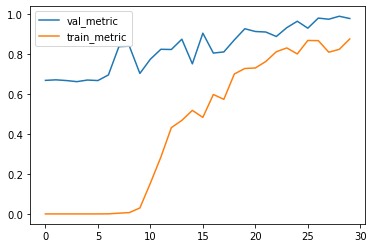

100%|██████████| 18/18 [00:01<00:00, 12.87it/s]


Epoch 31/300, epoch_loss 0.189, epoch_metric=0.892, val_loss 0.037, val_metric 0.972


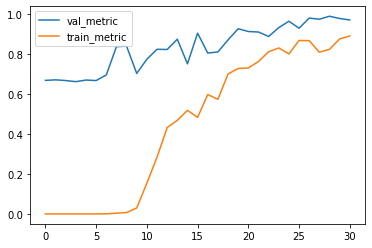

100%|██████████| 18/18 [00:01<00:00, 12.89it/s]

Epoch 32/300, epoch_loss 0.199, epoch_metric=0.894, val_loss 0.024, val_metric 0.990


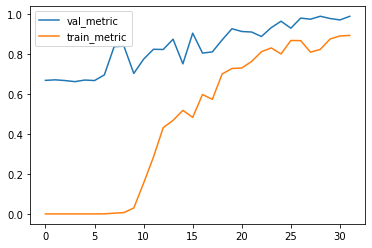

100%|██████████| 18/18 [00:01<00:00, 12.93it/s]

Epoch 33/300, epoch_loss 0.175, epoch_metric=0.907, val_loss 0.042, val_metric 0.987


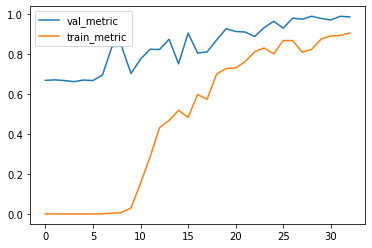

100%|██████████| 18/18 [00:01<00:00, 12.92it/s]

Epoch 34/300, epoch_loss 0.171, epoch_metric=0.917, val_loss 0.027, val_metric 0.981


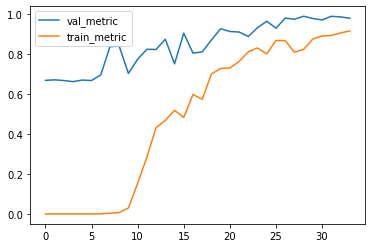

100%|██████████| 18/18 [00:01<00:00, 12.92it/s]


Epoch 35/300, epoch_loss 0.151, epoch_metric=0.922, val_loss 0.024, val_metric 0.992


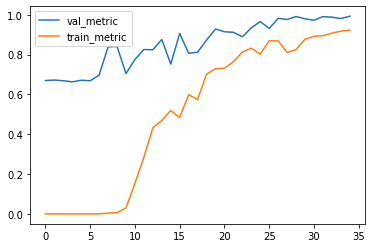

100%|██████████| 18/18 [00:01<00:00, 12.97it/s]


Epoch 36/300, epoch_loss 0.164, epoch_metric=0.920, val_loss 0.032, val_metric 0.997


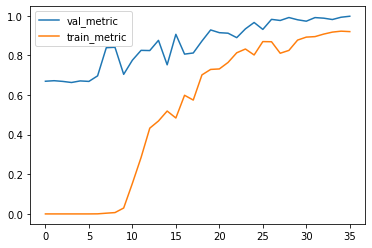

100%|██████████| 18/18 [00:01<00:00, 12.90it/s]

Epoch 37/300, epoch_loss 0.159, epoch_metric=0.922, val_loss 0.067, val_metric 0.992


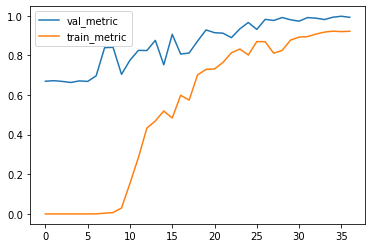

100%|██████████| 18/18 [00:01<00:00, 12.92it/s]

Epoch 38/300, epoch_loss 0.167, epoch_metric=0.918, val_loss 0.019, val_metric 0.993


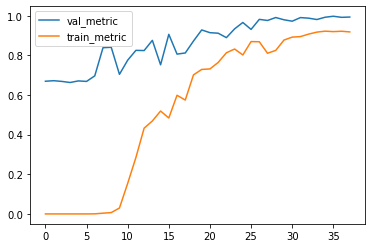

100%|██████████| 18/18 [00:01<00:00, 12.94it/s]

Epoch 39/300, epoch_loss 0.109, epoch_metric=0.950, val_loss 0.014, val_metric 0.991


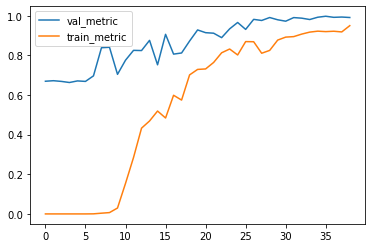

100%|██████████| 18/18 [00:01<00:00, 12.92it/s]

Epoch 40/300, epoch_loss 0.120, epoch_metric=0.941, val_loss 0.021, val_metric 0.984


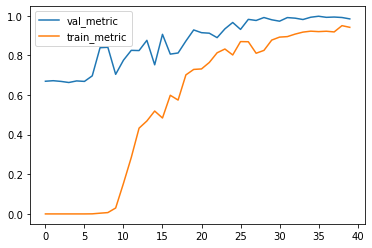

100%|██████████| 18/18 [00:01<00:00, 12.94it/s]

Epoch 41/300, epoch_loss 0.146, epoch_metric=0.933, val_loss 0.022, val_metric 0.995


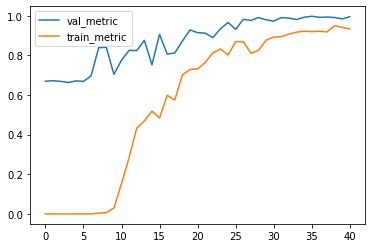

100%|██████████| 18/18 [00:01<00:00, 12.93it/s]

Epoch 42/300, epoch_loss 0.112, epoch_metric=0.949, val_loss 0.029, val_metric 0.972


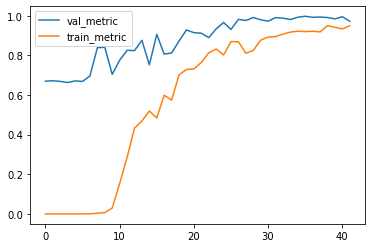

100%|██████████| 18/18 [00:01<00:00, 12.89it/s]


Epoch 43/300, epoch_loss 0.097, epoch_metric=0.954, val_loss 0.019, val_metric 0.999


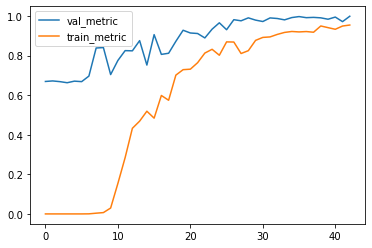

100%|██████████| 18/18 [00:01<00:00, 12.92it/s]

Epoch 44/300, epoch_loss 0.109, epoch_metric=0.951, val_loss 0.013, val_metric 0.993


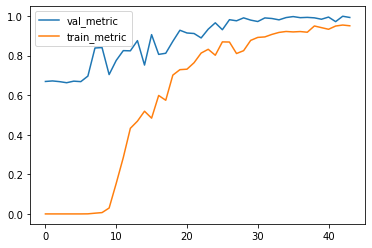

100%|██████████| 18/18 [00:01<00:00, 12.90it/s]

Epoch 45/300, epoch_loss 0.229, epoch_metric=0.892, val_loss 0.022, val_metric 0.998


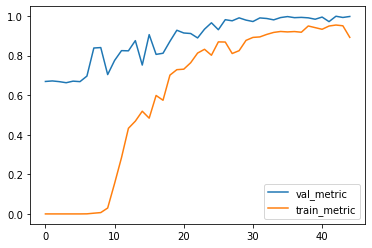

100%|██████████| 18/18 [00:01<00:00, 12.93it/s]

Epoch 46/300, epoch_loss 0.134, epoch_metric=0.935, val_loss 0.018, val_metric 0.993


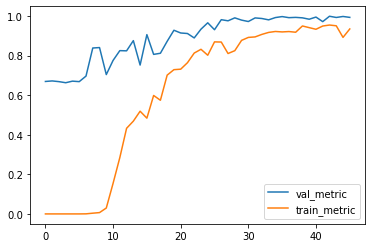

100%|██████████| 18/18 [00:01<00:00, 12.93it/s]

Epoch 47/300, epoch_loss 0.108, epoch_metric=0.947, val_loss 0.014, val_metric 0.995


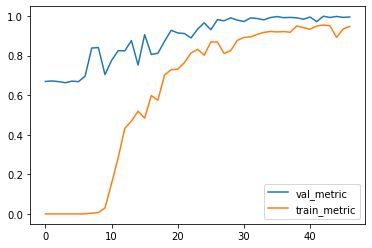

100%|██████████| 18/18 [00:01<00:00, 12.92it/s]

Epoch 48/300, epoch_loss 0.080, epoch_metric=0.963, val_loss 0.017, val_metric 0.985


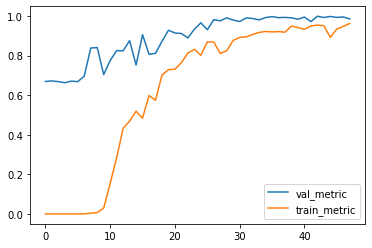

100%|██████████| 18/18 [00:01<00:00, 12.96it/s]

Epoch 49/300, epoch_loss 0.096, epoch_metric=0.955, val_loss 0.018, val_metric 0.998


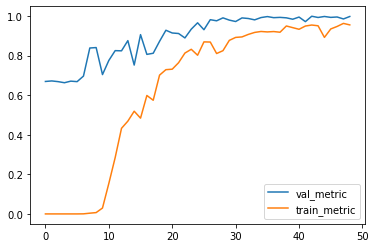

100%|██████████| 18/18 [00:01<00:00, 12.93it/s]

Epoch 50/300, epoch_loss 0.158, epoch_metric=0.930, val_loss 0.017, val_metric 0.998


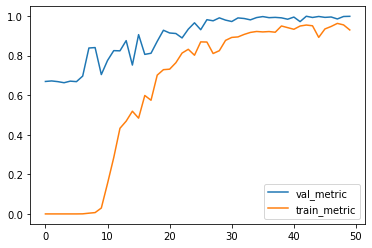

100%|██████████| 18/18 [00:01<00:00, 12.90it/s]


Epoch 51/300, epoch_loss 0.085, epoch_metric=0.959, val_loss 0.012, val_metric 0.999


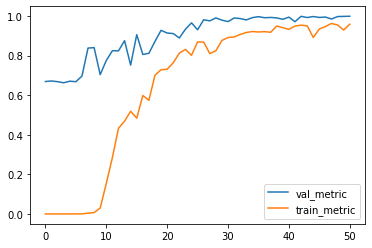

100%|██████████| 18/18 [00:01<00:00, 12.99it/s]

Epoch 52/300, epoch_loss 0.071, epoch_metric=0.970, val_loss 0.021, val_metric 0.996


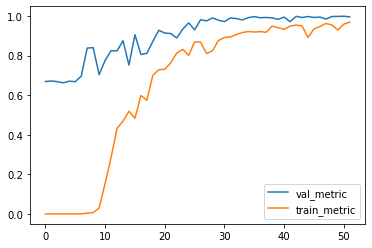

100%|██████████| 18/18 [00:01<00:00, 12.97it/s]

Epoch 53/300, epoch_loss 0.064, epoch_metric=0.970, val_loss 0.010, val_metric 0.999


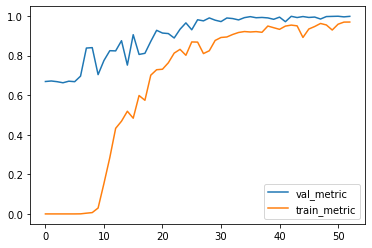

100%|██████████| 18/18 [00:01<00:00, 12.93it/s]

Epoch 54/300, epoch_loss 0.058, epoch_metric=0.973, val_loss 0.012, val_metric 0.998


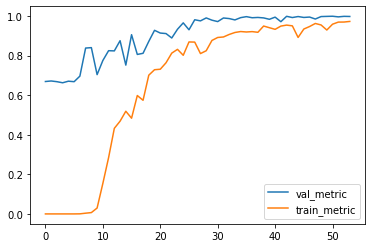

100%|██████████| 18/18 [00:01<00:00, 12.92it/s]

Epoch 55/300, epoch_loss 0.069, epoch_metric=0.970, val_loss 0.009, val_metric 0.999


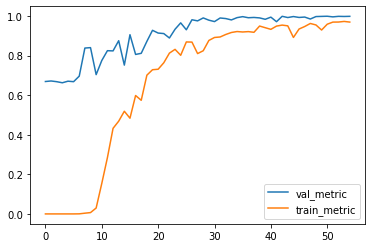

100%|██████████| 18/18 [00:01<00:00, 12.95it/s]

Epoch 56/300, epoch_loss 0.061, epoch_metric=0.974, val_loss 0.008, val_metric 0.999


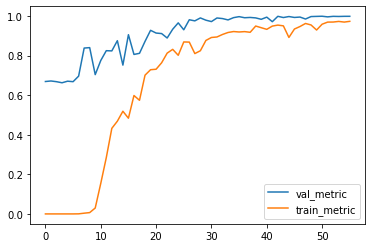

100%|██████████| 18/18 [00:01<00:00, 12.86it/s]

Epoch 57/300, epoch_loss 0.072, epoch_metric=0.969, val_loss 0.010, val_metric 0.992


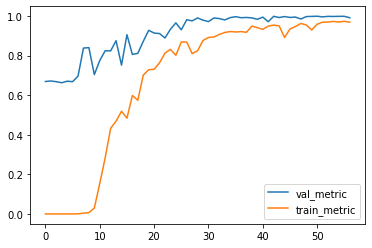

100%|██████████| 18/18 [00:01<00:00, 12.90it/s]


Epoch 58/300, epoch_loss 0.047, epoch_metric=0.975, val_loss 0.006, val_metric 1.000


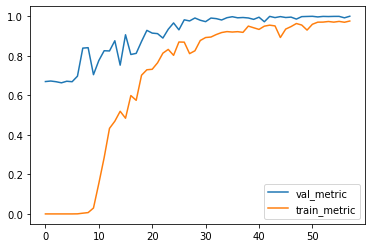

100%|██████████| 18/18 [00:01<00:00, 12.95it/s]

Epoch 59/300, epoch_loss 0.059, epoch_metric=0.975, val_loss 0.007, val_metric 0.999


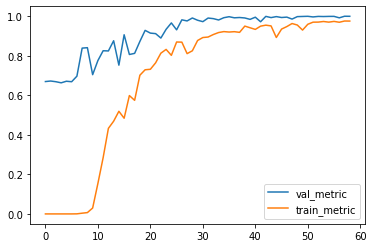

100%|██████████| 18/18 [00:01<00:00, 12.92it/s]


Epoch 60/300, epoch_loss 0.059, epoch_metric=0.973, val_loss 0.005, val_metric 1.000


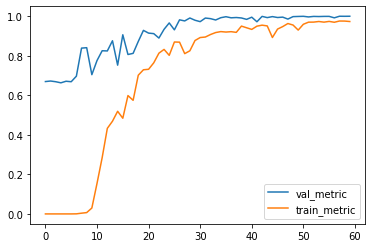

100%|██████████| 18/18 [00:01<00:00, 12.94it/s]

Epoch 61/300, epoch_loss 0.052, epoch_metric=0.979, val_loss 0.018, val_metric 0.997


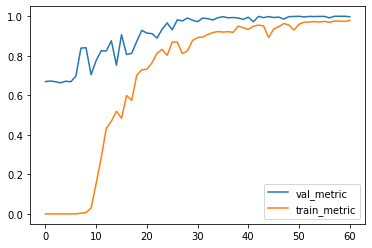

100%|██████████| 18/18 [00:01<00:00, 12.88it/s]

Epoch 62/300, epoch_loss 0.110, epoch_metric=0.951, val_loss 0.017, val_metric 0.998


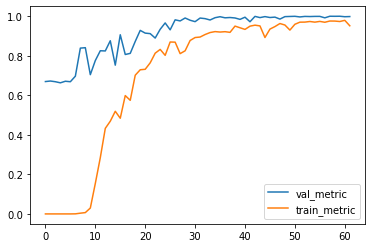

100%|██████████| 18/18 [00:01<00:00, 12.36it/s]


Epoch 63/300, epoch_loss 0.087, epoch_metric=0.963, val_loss 0.005, val_metric 1.000


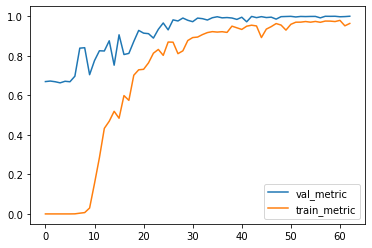

100%|██████████| 18/18 [00:01<00:00, 11.09it/s]

Epoch 64/300, epoch_loss 0.058, epoch_metric=0.976, val_loss 0.015, val_metric 0.998


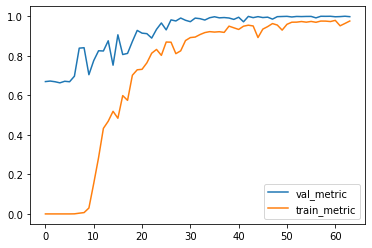

100%|██████████| 18/18 [00:01<00:00, 12.06it/s]

Epoch 65/300, epoch_loss 0.043, epoch_metric=0.981, val_loss 0.006, val_metric 1.000


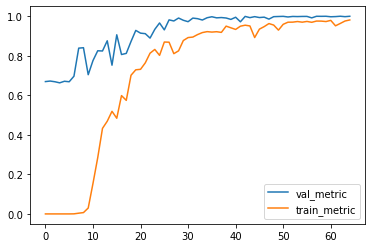

100%|██████████| 18/18 [00:01<00:00, 12.29it/s]

Epoch 66/300, epoch_loss 0.038, epoch_metric=0.986, val_loss 0.005, val_metric 1.000


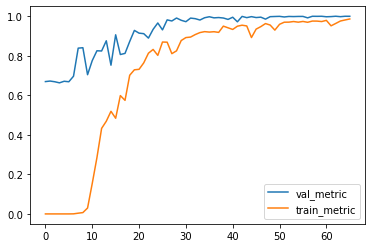

100%|██████████| 18/18 [00:01<00:00, 12.25it/s]


Epoch 67/300, epoch_loss 0.052, epoch_metric=0.977, val_loss 0.004, val_metric 1.000


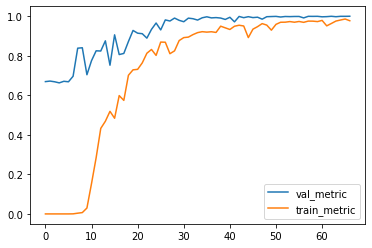

100%|██████████| 18/18 [00:01<00:00, 11.87it/s]


Epoch 68/300, epoch_loss 0.049, epoch_metric=0.980, val_loss 0.005, val_metric 1.000


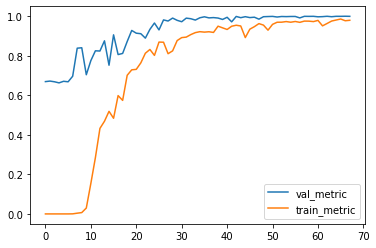

100%|██████████| 18/18 [00:01<00:00, 12.68it/s]

Epoch 69/300, epoch_loss 0.042, epoch_metric=0.983, val_loss 0.005, val_metric 0.999


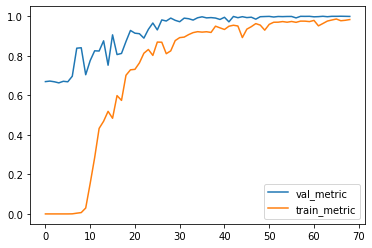

100%|██████████| 18/18 [00:01<00:00, 11.85it/s]

Epoch 70/300, epoch_loss 0.051, epoch_metric=0.979, val_loss 0.006, val_metric 0.999


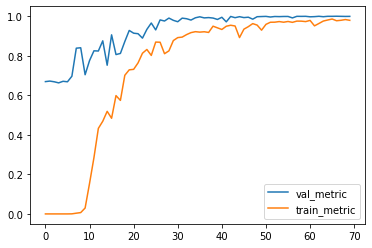

100%|██████████| 18/18 [00:01<00:00, 12.33it/s]


Epoch 71/300, epoch_loss 0.044, epoch_metric=0.981, val_loss 0.009, val_metric 0.999


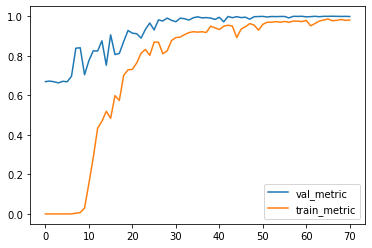

 41%|████      | 34/83 [00:08<00:11,  4.23it/s]


KeyboardInterrupt: 

In [16]:
# Compute F1 score metric
def compute_metric(model, metric=BinaryF1Score(), loader=None):
    model.eval()
    criterion = ContrastiveLoss()
    if loader is None:
        loader = val_loader

    running_loss = 0.0
    running_metric = 0.0
    compare = torch.nn.CosineSimilarity(dim=1)
    with torch.no_grad():
        for i, (left, right, score) in tqdm.tqdm(enumerate(loader), total=len(loader)):
            left = left.to(device)
            right = right.to(device)
            score = score.to(device)
            out0, out1 = model(left, right)
            loss = criterion(out0, out1, 1-score)
            running_loss += loss.item()

            similarities = model.compare_embeddings(out0, out1)
            # Compute cosine similarity
            running_metric += metric(score, (similarities < 0.5).float()).item()

    return running_loss/len(loader), running_metric/len(loader)

val_losses = []
train_losses = []
val_metrics = []
train_metrics = []
best_metric = 0


for epoch in range(N):
    model.train()
    running_epoch_loss = 0.0
    running_epoch_metric = 0.0

    for i, (left, right, score) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        
        left = left.to(device)
        right = right.to(device)
        score = score.to(device)
        # Runtime augmentation
        left = transform(left)
        right = transform(right)

        optimizer.zero_grad()
        out0, out1 = model(left, right)
        loss = criterion(out0, out1, 1-score)
        running_epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        similarities = model.compare_embeddings(out0, out1)

        # Compute cosine similarity
        running_epoch_metric += metric(score, (similarities < 0.5).float()).item()

    # Epoch complete
    val_loss, val_metric = compute_metric(model, loader=val_loader, metric=metric)
    train_loss, train_metric = running_epoch_loss/len(train_loader), running_epoch_metric/len(train_loader) 
    print(f"Epoch {epoch+1}/{N}, epoch_loss {train_loss:.3f}, epoch_metric={train_metric:.3f}, val_loss {val_loss:.3f}, val_metric {val_metric:.3f}")

    val_losses.append(val_loss)
    train_losses.append(train_loss)
    val_metrics.append(val_metric)
    train_metrics.append(train_metric)

    if val_metric >= best_metric:
        best_metric = val_metric
        torch.save(model.state_dict(), "bestmodel2.pt")

    # plt.plot(val_losses, label="val_loss")
    # plt.plot(train_losses, label="train_loss")
    plt.plot(val_metrics, label="val_metric")
    plt.plot(train_metrics, label="train_metric")
    plt.legend()
    plt.show()
    
    
      



In [18]:
torch.save(model.state_dict(), "modelbest_80epochs.pt")

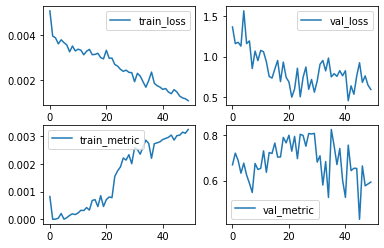

In [ ]:
plt.subplot(2, 2, 1).plot(train_losses, label="train_loss")
plt.subplot(2, 2, 2).plot(val_losses, label="val_loss")
plt.subplot(2, 2, 3).plot([x.cpu() for x in train_metrics], label="train_metric")
plt.subplot(2, 2, 4).plot([x.cpu() for x in val_metrics], label="val_metric")
plt.subplot(2, 2, 1).legend()
plt.subplot(2, 2, 2).legend()
plt.subplot(2, 2, 3).legend()
plt.subplot(2, 2, 4).legend()